In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
from zipfile import ZipFile
file_name = "/content/sentiment140.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [6]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import pickle

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
dataset_path = '/content/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(dataset_path, encoding='latin-1', header=None)

In [9]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

df['label'] = df['target'].map({0: 0, 2: 1, 4: 2})

In [11]:
df.head()

,target,id,date,flag,user,text,label
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0


In [12]:
df['label'].value_counts()

,count
label,
0,800000
2,800000


In [13]:
# Drop unnecessary columns
df = df[['text', 'label']]

In [14]:
def stemming (content):
  port_stem = PorterStemmer()
  stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if word not in stopwords.words('english')]
  return ' '.join(stemmed_content)

In [15]:
df['text'] = df['text'].apply(stemming)

In [16]:
df.head()

,text,label
0,switchfoot http twitpic com zl awww bummer sho...,0
1,upset updat facebook text might cri result sch...,0
2,kenichan dive mani time ball manag save rest g...,0
3,whole bodi feel itchi like fire,0
4,nationwideclass behav mad see,0


In [17]:
X=df['text'].values
y=df['label'].values

In [18]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=2)

In [19]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

****Train Machine Learning Model****

In [20]:
model=MultinomialNB()
model.fit(X_train,Y_train)

MultinomialNB()

In [21]:
X_train_prediction=model.predict(X_train)
training_data_accuracy=accuracy_score(X_train_prediction,Y_train)

In [22]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.8200265625


In [23]:
X_test_prediction=model.predict(X_test)
test_data_accuracy=accuracy_score(X_test_prediction,Y_test)

In [24]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.755815625


In [25]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, X_test_prediction))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76    160000
           2       0.77      0.73      0.75    160000

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



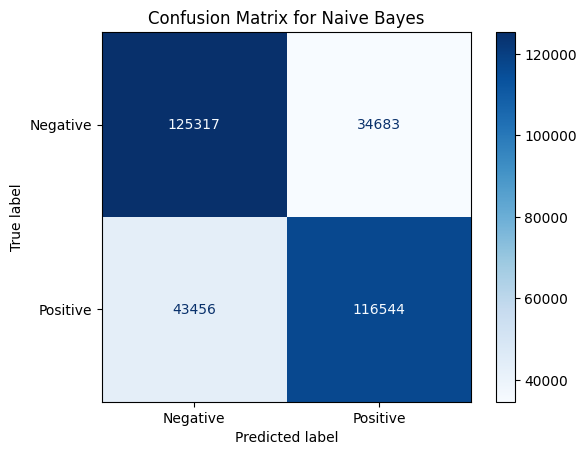

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

Y_test_predictions = model.predict(X_test)

cm = confusion_matrix(Y_test, Y_test_predictions)

# Get unique classes from your predictions and true labels
unique_classes = np.unique(np.concatenate((Y_test, Y_test_predictions)))

# Define display labels based on unique classes
display_labels = ["Negative", "Neutral", "Positive"]  # Original labels
# Filter labels to match unique classes
display_labels = [display_labels[i] for i in unique_classes]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Naive Bayes")
plt.show()

In [25]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer.sav', 'wb'))

In [26]:
model = pickle.load(open('model.pkl', 'rb'))

vectorizer = pickle.load(open('vectorizer.sav', 'rb'))

In [27]:
def predict_sentiment(text):
    processed_text = stemming(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    return prediction

In [ ]:
custom_text = "This is a low rating movie!"
sentiment = predict_sentiment(custom_text)
if sentiment == 0:
    print("Negative sentiment")
elif sentiment == 1:
    print("Neutral sentiment")
else:
    print("Positive sentiment")

Negative sentiment
